In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 200

ng =10

ng_refs = (/ 2 , 2 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.7/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

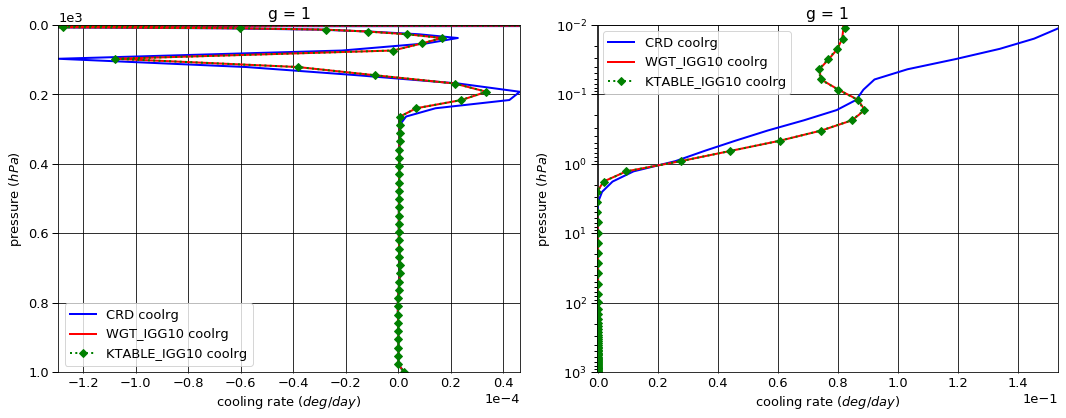

# Figure: cooling rate g-group 2

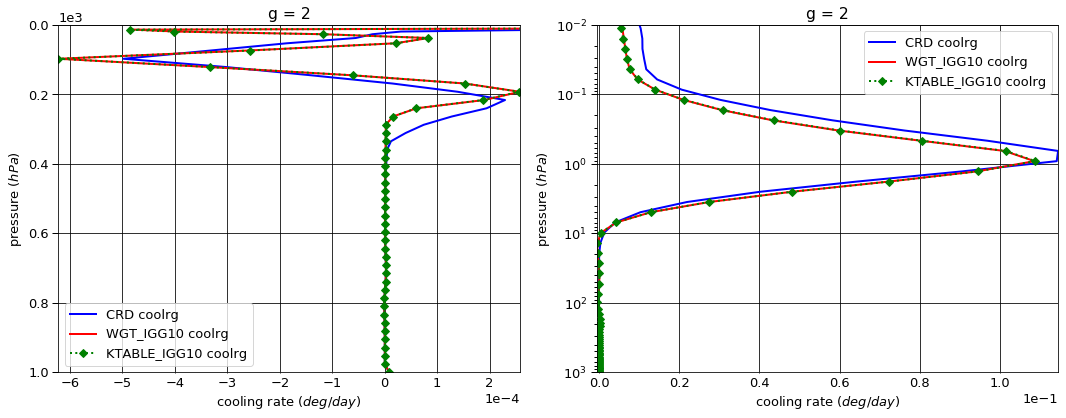

# Figure: cooling rate g-group 3

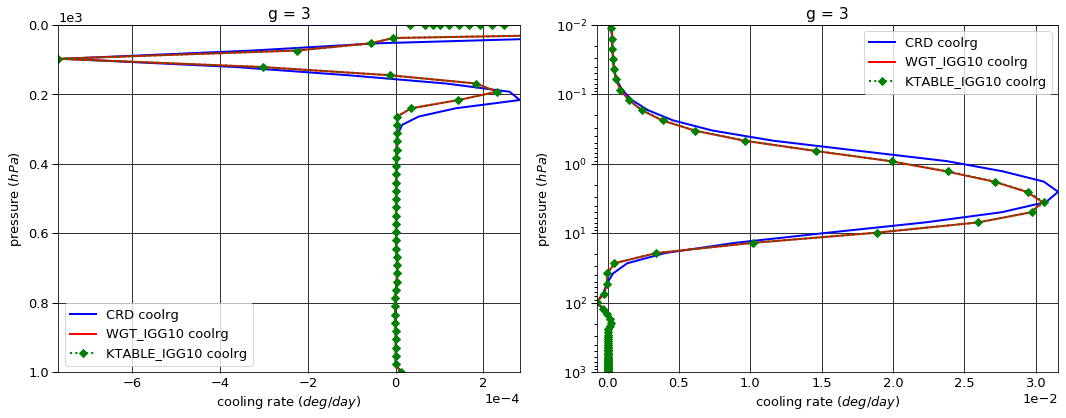

# Figure: cooling rate g-group 4

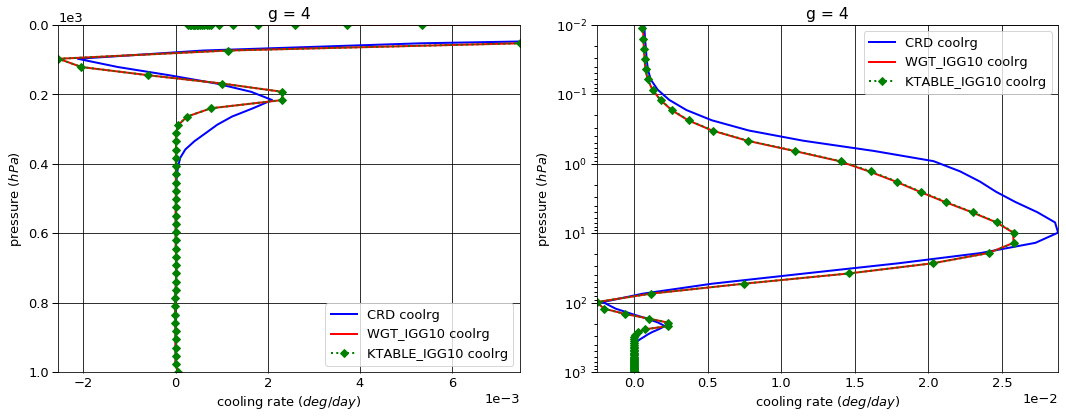

# Figure: cooling rate g-group 5

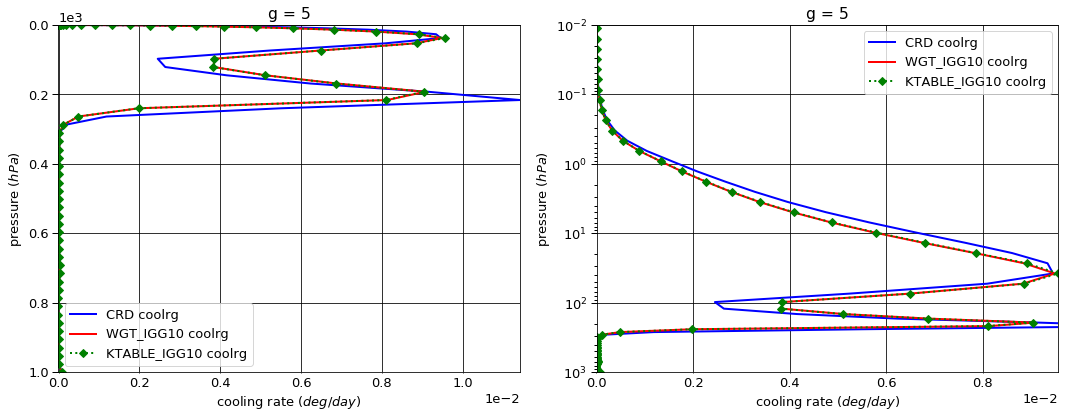

# Figure: cooling rate g-group 6

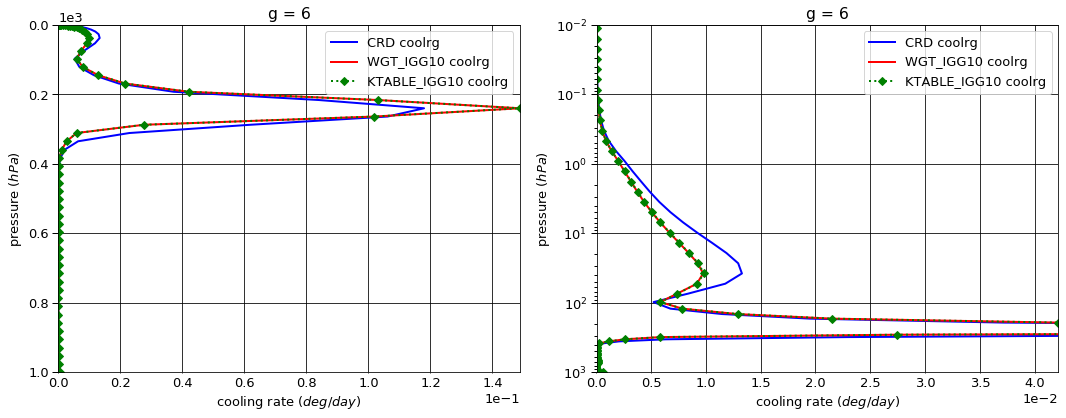

# Figure: cooling rate g-group 7

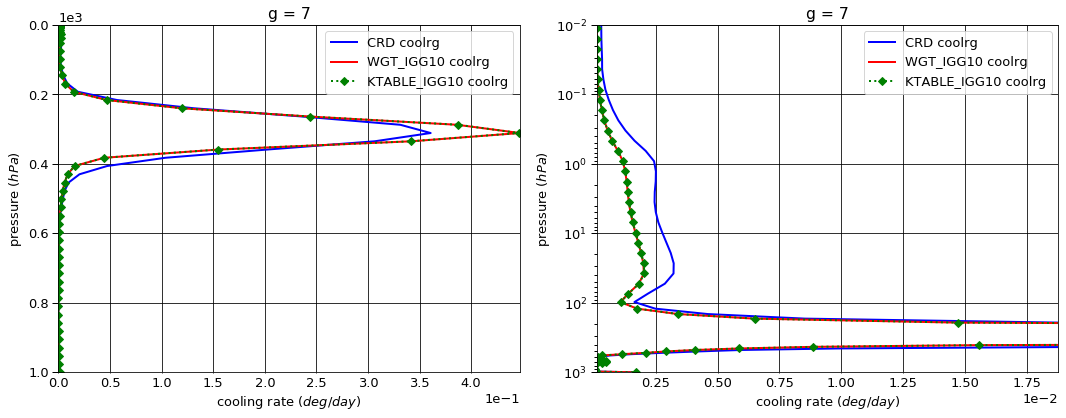

# Figure: cooling rate g-group 8

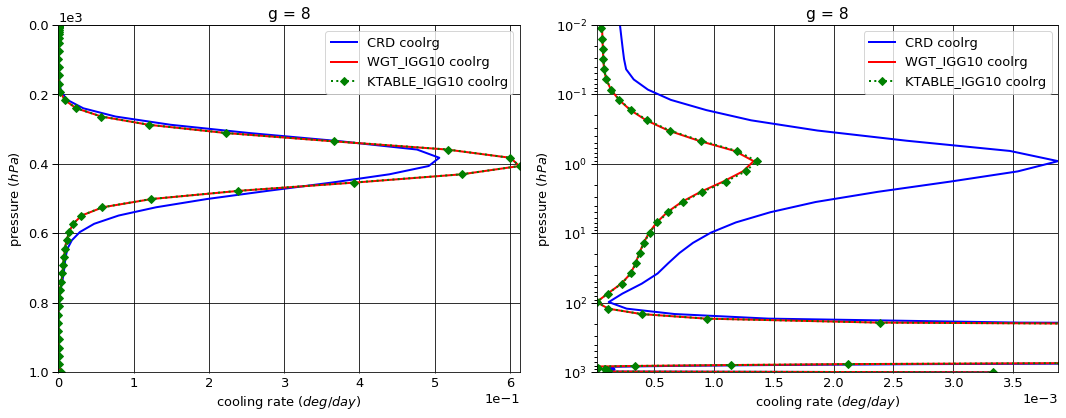

# Figure: cooling rate g-group 9

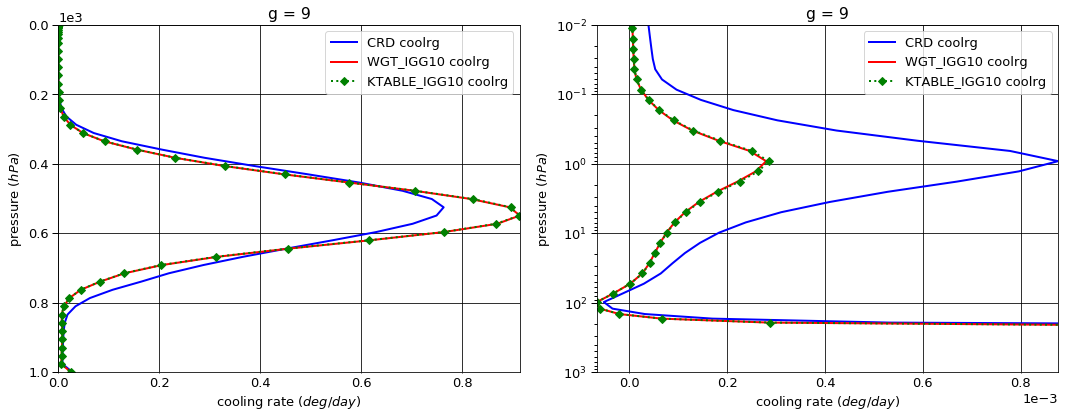

# Figure: cooling rate g-group 10

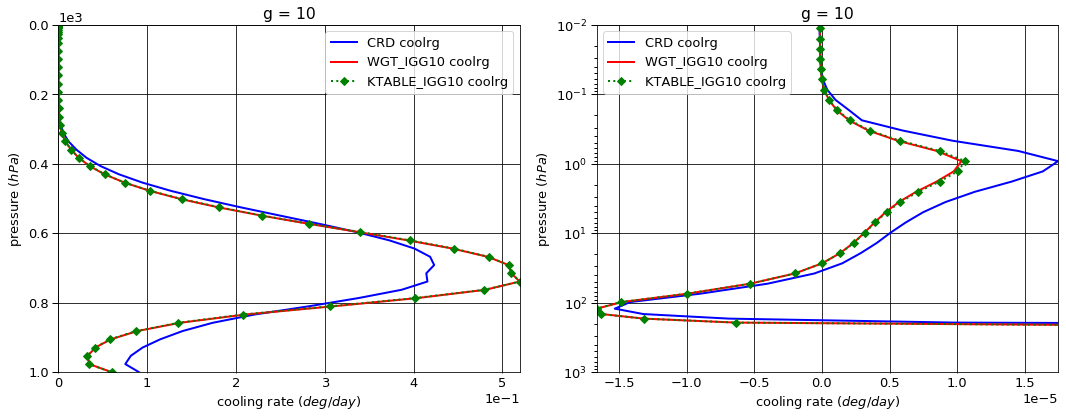

# Figure: cooling rate g-group total

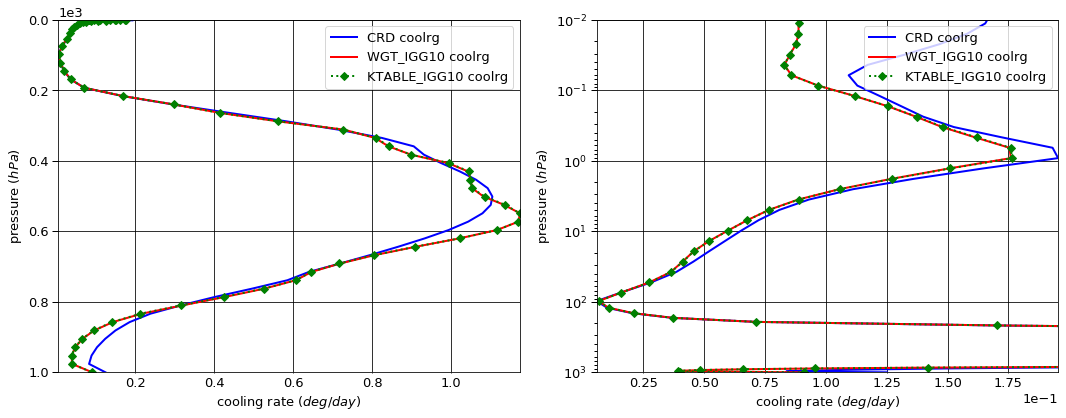

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007132   0.000000  -0.007132
   1013.0   76     -0.011993   0.011987  -0.000006
2  0.0      1      -0.029587   0.000000  -0.029587
   1013.0   76     -0.044360   0.044336  -0.000024
3  0.0      1      -0.038569   0.000000  -0.038569
   1013.0   76     -0.065790   0.065757  -0.000033
4  0.0      1      -0.136140   0.000000  -0.136140
   1013.0   76     -0.286670   0.286522  -0.000148
5  0.0      1      -0.195087   0.000000  -0.195087
   1013.0   76     -0.447779   0.447560  -0.000219
6  0.0      1      -1.470005   0.000000  -1.470005
   1013.0   76     -3.055224   3.053652  -0.001572
7  0.0      1      -5.275596   0.000000  -5.275596
   1013.0   76     -9.310440   9.305658  -0.004782
8  0.0      1     -11.315602   0.000000 -11.315602
   1013.0   76    -17.585004  17.575695  -0.009309
9  0.0      1     -24.947944   0.000000 -24.947944
   1013.0   76    -34.046009  33.970570  -0.075438
10 0.0      1     -17.717781   0.000000 -17.717781
   1013.0   76    -21.621961  21.087856  -0.534105


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007242   0.000000  -0.007242
   1013.0   76     -0.011993   0.011987  -0.000006
2  0.0      1      -0.030162   0.000000  -0.030162
   1013.0   76     -0.044360   0.044336  -0.000024
3  0.0      1      -0.038927   0.000000  -0.038927
   1013.0   76     -0.065790   0.065757  -0.000033
4  0.0      1      -0.129684   0.000000  -0.129684
   1013.0   76     -0.286670   0.286522  -0.000148
5  0.0      1      -0.188140   0.000000  -0.188140
   1013.0   76     -0.447779   0.447560  -0.000219
6  0.0      1      -1.444096   0.000000  -1.444096
   1013.0   76     -3.055224   3.053652  -0.001572
7  0.0      1      -5.252261   0.000000  -5.252261
   1013.0   76     -9.310440   9.305658  -0.004782
8  0.0      1     -11.268095   0.000000 -11.268095
   1013.0   76    -17.585004  17.575720  -0.009284
9  0.0      1     -24.955537   0.000000 -24.955537
   1013.0   76    -34.046009  33.981607  -0.064401
10 0.0      1     -17.672211   0.000000 -17.672211
   1013.0   76    -21.621961  21.407729  -0.214232


KTABLE_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007242   0.000000  -0.007242
   1013.0   76     -0.011993   0.011987  -0.000006
2  0.0      1      -0.030171   0.000000  -0.030171
   1013.0   76     -0.044360   0.044336  -0.000024
3  0.0      1      -0.038938   0.000000  -0.038938
   1013.0   76     -0.065790   0.065757  -0.000033
4  0.0      1      -0.129725   0.000000  -0.129725
   1013.0   76     -0.286670   0.286522  -0.000148
5  0.0      1      -0.188126   0.000000  -0.188126
   1013.0   76     -0.447779   0.447560  -0.000219
6  0.0      1      -1.443740   0.000000  -1.443740
   1013.0   76     -3.055224   3.053652  -0.001572
7  0.0      1      -5.251113   0.000000  -5.251113
   1013.0   76     -9.310440   9.305658  -0.004782
8  0.0      1     -11.264985   0.000000 -11.264985
   1013.0   76    -17.585004  17.575720  -0.009284
9  0.0      1     -24.946905   0.000000 -24.946905
   1013.0   76    -34.046009  33.981922  -0.064086
10 0.0      1     -17.663930   0.000000 -17.663930
   1013.0   76    -21.621961  21.409800  -0.212161


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000111  0.000000e+00 -1.106968e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1     -0.000576  0.000000e+00 -5.756290e-04
   1013.0   76     0.000000 -6.938894e-18  0.000000e+00
3  0.0      1     -0.000358  0.000000e+00 -3.581960e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1      0.006456  0.000000e+00  6.455540e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
5  0.0      1      0.006947  0.000000e+00  6.946840e-03
   1013.0   76     0.000000  0.000000e+00  2.710505e-20
6  0.0      1      0.025908  0.000000e+00  2.590850e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1      0.023335  0.000000e+00  2.333520e-02
   1013.0   76     0.000000  1.776357e-15  0.000000e+00
8  0.0      1      0.047507  0.000000e+00  4.750700e-02
   1013.0   76     0.000000  2.500000e-05  2.513830e-05
9  0.0      1     -0.007593  0.000000e+00 -7.593000e-03
   1013.0   76     0.000000  1.103700e-02  1.103702e-02
10 0.0      1      0.045570  0.000000e+00  4.557000e-02
   1013.0   76     0.000000  3.198730e-01  3.198729e-01


KTABLE_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000110  0.000000e+00 -1.103524e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1     -0.000585  0.000000e+00 -5.846340e-04
   1013.0   76     0.000000 -6.938894e-18  0.000000e+00
3  0.0      1     -0.000369  0.000000e+00 -3.690390e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1      0.006415  0.000000e+00  6.414880e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
5  0.0      1      0.006961  0.000000e+00  6.960900e-03
   1013.0   76     0.000000  0.000000e+00  2.710505e-20
6  0.0      1      0.026264  0.000000e+00  2.626450e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1      0.024483  0.000000e+00  2.448310e-02
   1013.0   76     0.000000  1.776357e-15  0.000000e+00
8  0.0      1      0.050617  0.000000e+00  5.061700e-02
   1013.0   76     0.000000  2.500000e-05  2.513830e-05
9  0.0      1      0.001039  0.000000e+00  1.039000e-03
   1013.0   76     0.000000  1.135200e-02  1.135182e-02
10 0.0      1      0.053851  0.000000e+00  5.385100e-02
   1013.0   76     0.000000  3.219440e-01  3.219436e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.588081e-01
   1001.112500 75     2.155708e-06
2  0.000312    1      5.505852e-03
   1001.112500 75     8.495683e-06
3  0.000312    1      1.478737e-04
   1001.112500 75     1.198679e-05
4  0.000312    1      4.772974e-04
   1001.112500 75     5.312823e-05
5  0.000312    1      3.098103e-07
   1001.112500 75     7.888332e-05
6  0.000312    1      2.285972e-05
   1001.112500 75     5.654346e-04
7  0.000312    1      2.319098e-04
   1001.112500 75     1.719468e-03
8  0.000312    1      1.440039e-04
   1001.112500 75     3.347412e-03
9  0.000312    1      2.128949e-05
   1001.112500 75     2.829003e-02
10 0.000312    1     -3.126923e-07
   1001.112500 75     9.107953e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      6.914419e-02
   1001.112500 75     2.155708e-06
2  0.000312    1      3.203082e-03
   1001.112500 75     8.495683e-06
3  0.000312    1      1.707833e-04
   1001.112500 75     1.198679e-05
4  0.000312    1      4.446402e-04
   1001.112500 75     5.312823e-05
5  0.000312    1      2.769534e-07
   1001.112500 75     7.888332e-05
6  0.000312    1      1.651548e-05
   1001.112500 75     5.654346e-04
7  0.000312    1      8.448060e-05
   1001.112500 75     1.719468e-03
8  0.000312    1      3.890699e-05
   1001.112500 75     3.337805e-03
9  0.000312    1      1.067333e-06
   1001.112500 75     2.537262e-02
10 0.000312    1     -2.269541e-07
   1001.112500 75     6.045364e-02


KTABLE_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      7.151017e-02
   1001.112500 75     2.155708e-06
2  0.000312    1      2.352984e-03
   1001.112500 75     8.495683e-06
3  0.000312    1      3.180198e-05
   1001.112500 75     1.198679e-05
4  0.000312    1      2.784464e-04
   1001.112500 75     5.312823e-05
5  0.000312    1     -6.411521e-06
   1001.112500 75     7.888332e-05
6  0.000312    1      5.950456e-06
   1001.112500 75     5.654346e-04
7  0.000312    1      7.742354e-05
   1001.112500 75     1.719468e-03
8  0.000312    1      2.782037e-05
   1001.112500 75     3.337805e-03
9  0.000312    1      8.786124e-07
   1001.112500 75     2.524265e-02
10 0.000312    1     -1.353078e-07
   1001.112500 75     6.008176e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -8.966390e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -2.302770e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      2.290961e-05
   1001.112500 75     0.000000e+00
4  0.000312    1     -3.265719e-05
   1001.112500 75     6.776264e-21
5  0.000312    1     -3.285693e-08
   1001.112500 75     0.000000e+00
6  0.000312    1     -6.344240e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.474292e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.050969e-04
   1001.112500 75    -9.607800e-06
9  0.000312    1     -2.022216e-05
   1001.112500 75    -2.917407e-03
10 0.000312    1      8.573820e-08
   1001.112500 75    -3.062589e-02


KTABLE_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -8.729792e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -3.152867e-03
   1001.112500 75     0.000000e+00
3  0.000312    1     -1.160717e-04
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.988510e-04
   1001.112500 75     6.776264e-21
5  0.000312    1     -6.721331e-06
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.690926e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.544863e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.161835e-04
   1001.112500 75    -9.607800e-06
9  0.000312    1     -2.041088e-05
   1001.112500 75    -3.047381e-03
10 0.000312    1      1.773844e-07
   1001.112500 75    -3.099776e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.133442,0.000000,-61.133442
1013.0,76,-86.475230,85.849593,-0.625636



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.986356,0.000000,-60.986356
1013.0,76,-86.475230,86.180528,-0.294701



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.964876,0.000000,-60.964876
1013.0,76,-86.475230,86.182914,-0.292316



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.147086,0.000000,0.147086
1013.0,76,0.000000,0.330935,0.330935



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.168566,0.000000,0.168566
1013.0,76,0.000000,0.333321,0.333321


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.165359
1001.112500,75,0.125157



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.073104
1001.112500,75,0.091604



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.074279
1001.112500,75,0.091102



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.092255
1001.112500,75,-0.033553



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.091080
1001.112500,75,-0.034055


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000150,0.000145
2,0.000525,0.000521
3,0.000825,0.000792
4,0.003525,0.003422
5,0.005775,0.005468
6,0.037575,0.036493
7,0.114900,0.111318
8,0.211525,0.207564
9,0.390375,0.393311


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.384515e-18
2,5.623149e-19
3,4.227122e-19
4,4.626733e-20
5,1.509806e-19
6,1.832682e-20
7,2.224606e-21
8,2.700344e-22
9,3.277820e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.384515e-18,NaN,0.000150,0.000145,0.000150,0.000145,1.0
2,5.623149e-19,0.104432,0.000525,0.000521,0.000675,0.000666,1.0
3,4.227122e-19,0.751736,0.000825,0.000792,0.001500,0.001458,10.0
4,4.626733e-20,0.109454,0.003525,0.003422,0.005025,0.004880,10.0
5,1.509806e-19,3.263222,0.005775,0.005468,0.010800,0.010347,500.0
6,1.832682e-20,0.121385,0.037575,0.036493,0.048375,0.046840,500.0
7,2.224606e-21,0.121385,0.114900,0.111318,0.163275,0.158159,500.0
8,2.700344e-22,0.121385,0.211525,0.207564,0.374800,0.365723,500.0
9,3.277820e-23,0.121385,0.390375,0.393311,0.765175,0.759034,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.424697e-17  1.211282e-17   2.001761  1.173969e-03
      2  0.000312     7.174835e-19  3.531592e-19   2.031615  3.451983e-05
      3  0.000312     7.888899e-21  7.237039e-21   1.090073  5.187973e-07
      4  0.000312     3.875254e-21  2.196008e-21   1.764681  1.984264e-07
      5  0.000312     9.480747e-25  9.477001e-25   1.000395  6.558499e-11
      6  0.000312     1.226542e-23  9.459104e-24   1.296679  7.321793e-10
      7  0.000312     5.254315e-23  5.652066e-24   9.296273  1.688908e-09
      8  0.000312     2.351577e-23  1.186937e-24  19.812151  7.001316e-10
      9  0.000312     3.955195e-24  1.317692e-25  30.016073  1.149400e-10
      10 0.000312     6.881170e-26  1.408553e-26   4.885275  3.625310e-12
2     1  0.000750     2.427980e-17  1.212825e-17   2.001922  4.734830e-04
      2  0.000750     7.225177e-19  3.559618e-19   2.029762  1.400712e-05
      3  0.000750     8.016371e-21  7.351986e-21   1.090368  2.123079e-07
      4  0.000750     3.914300e-21  2.214520e-21   1.767562  8.066837e-08
      5  0.000750     1.312610e-24  1.312220e-24   1.000297  3.657617e-11
      6  0.000750     1.243662e-23  9.594096e-24   1.296278  2.990779e-10
      7  0.000750     5.270757e-23  5.686216e-24   9.269357  6.826736e-10
      8  0.000750     2.370325e-23  1.192035e-24  19.884694  2.841791e-10
      9  0.000750     3.980431e-24  1.324505e-25  30.052223  4.658900e-11
      10 0.000750     6.947714e-26  1.417698e-26   4.900699  1.473974e-12
3     1  0.001052     2.434834e-17  1.215964e-17   2.002390  6.658135e-04
      2  0.001052     7.327315e-19  3.615458e-19   2.026663  1.993401e-05
      3  0.001052     8.235003e-21  7.544560e-21   1.091515  3.056716e-07
      4  0.001052     3.989033e-21  2.247090e-21   1.775200  1.150603e-07
      5  0.001052     1.585809e-24  1.585393e-24   1.000263  6.197121e-11
      6  0.001052     1.268669e-23  9.769716e-24   1.298573  4.274506e-10
      7  0.001052     5.303673e-23  5.745298e-24   9.231328  9.639033e-10
      8  0.001052     2.408779e-23  1.201190e-24  20.053274  4.047551e-10
      9  0.001052     4.032176e-24  1.337090e-25  30.156353  6.617425e-11
      10 0.001052     7.083263e-26  1.434712e-26   4.937061  2.106160e-12
4     1  0.001476     2.441700e-17  1.219128e-17   2.002825  9.366114e-04
      2  0.001476     7.432549e-19  3.673291e-19   2.023403  2.838633e-05
      3  0.001476     8.470602e-21  7.752817e-21   1.092584  4.408430e-07
      4  0.001476     4.067404e-21  2.281583e-21   1.782711  1.642709e-07
      5  0.001476     1.964867e-24  1.964420e-24   1.000228  1.077223e-10
      6  0.001476     1.296430e-23  9.970420e-24   1.300276  6.123588e-10
      7  0.001476     5.337526e-23  5.807993e-24   9.189965  1.361740e-09
      8  0.001476     2.448527e-23  1.210851e-24  20.221549  5.768634e-10
      9  0.001476     4.085436e-24  1.350198e-25  30.258053  9.404657e-11
      10 0.001476     7.224310e-26  1.452311e-26   4.974355  3.011746e-12
5     1  0.002070     2.448463e-17  1.222273e-17   2.003205  1.317210e-03
      2  0.002070     7.539603e-19  3.732533e-19   2.019970  4.041699e-05
      3  0.002070     8.724686e-21  7.978629e-21   1.093507  6.365567e-07
      4  0.002070     4.148961e-21  2.318076e-21   1.789830  2.345970e-07
      5  0.002070     2.493119e-24  2.492636e-24   1.000194  1.917140e-10
      6  0.002070     1.327595e-23  1.020366e-23   1.301097  8.792365e-10
      7  0.002070     5.371938e-23  5.874530e-24   9.144455  1.923614e-09
      8  0.002070     2.489072e-23  1.221022e-24  20.385161  8.220430e-10
      9  0.002070     4.139517e-24  1.363778e-25  30.353305  1.336348e-10
      10 0.002070     7.369271e-26  1.470416e-26   5.011690  4.306452e-12
6     1  0.002904     2.455093e-17  1.225393e-17   2.003515  1.852581e-03
      2  0.002904     7.648597e-19  3.793400e-19   2.016291  5.755874e-05
      3  0.002904     9.003064e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
